In [1]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
from tqdm.contrib import itertools
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [2]:
tds = pd.read_csv('titanic.csv')

In [3]:
tds

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Text(0.5, 1.0, 'Missing values heatmap')

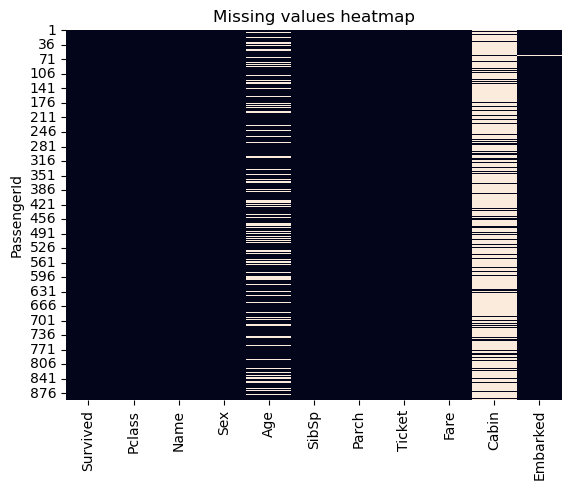

In [4]:
tds.set_index('PassengerId', inplace = True)
sns.heatmap(tds.isnull(), cbar = False).set_title("Missing values heatmap")

Text(0.5, 1.0, 'Percentage of people survived and Deceased')

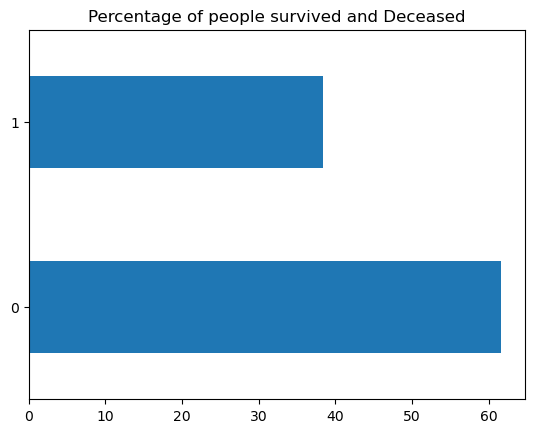

In [5]:
(tds.Survived.value_counts(normalize=True) * 100).plot.barh().set_title("Percentage of people survived and Deceased")

In [6]:
tds["Sex"].replace(["male", "female"], [0, 1], inplace = True)

#Iterate over Sex (0 or 1) and Pclass (3, 2, 1) to calculate guessed values of Age for the six combinations.
guess_ages = np.zeros((2,3))


for i in range(0, 2):
    for j in range(0, 3):
        guess_df = tds[(tds['Sex'] == i) & \
                              (tds['Pclass'] == j+1)]['Age'].dropna()

        age_guess = guess_df.median()

        # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

for i in range(0, 2):
    for j in range(0, 3):
        tds.loc[ (tds.Age.isnull()) & (tds.Sex == i) & (tds.Pclass == j+1),\
                'Age'] = guess_ages[i,j]

tds['Age'] = tds['Age'].astype(int)

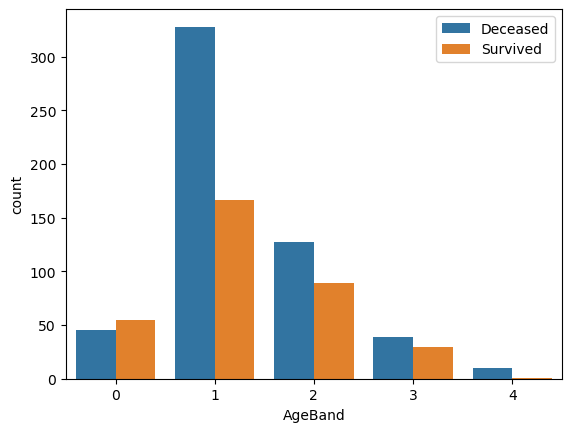

In [7]:
#Plot the relation between age and survival
tds['AgeBand'] = pd.cut(tds['Age'], 5, labels = ["0", "1", "2", "3", "4"])
tds['AgeBand'] = tds['AgeBand'].astype(int)
sns.countplot(x = "AgeBand", hue = "Survived", data = tds, palette=["C0", "C1"]).legend(labels = ["Deceased", "Survived"])

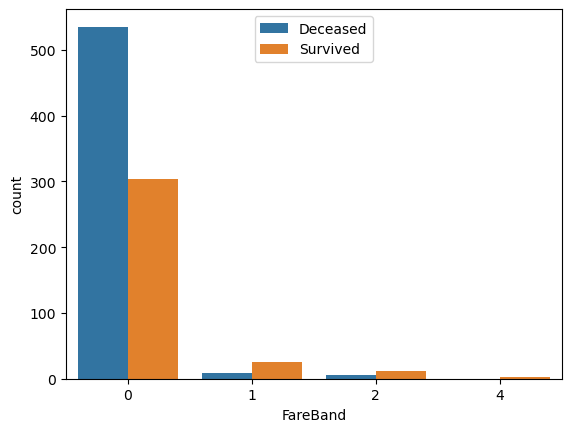

In [8]:
#Plot the relation between fare and survival
tds['FareBand'] = pd.cut(tds['Fare'], 5, labels = ["0", "1", "2", "3", "4"])
tds['FareBand'] = tds['FareBand'].astype(int)
sns.countplot(x = "FareBand", hue = "Survived", data = tds, palette=["C0", "C1"]).legend(labels = ["Deceased", "Survived"])

Text(0.5, 1.0, 'Survival based on embarking point')

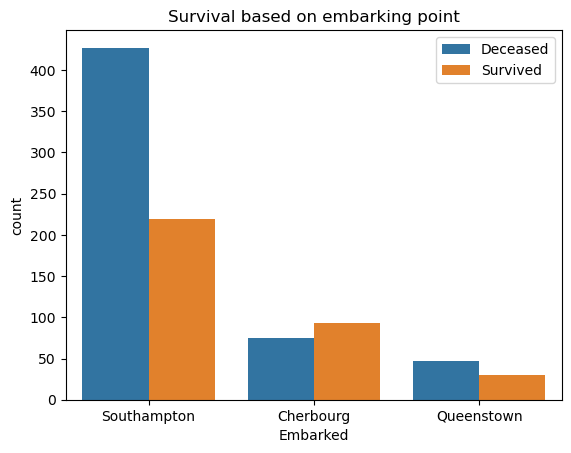

In [9]:
#Embarked has 1 missing value hence we fill it with the most common occurence
tds['Embarked'] = tds['Embarked'].fillna(tds.Embarked.dropna().mode()[0])

#Plot the relation between embarked and survival
p = sns.countplot(x = "Embarked", hue = "Survived", data = tds, palette=["C0", "C1"])
p.set_xticklabels(["Southampton","Cherbourg","Queenstown"])
p.legend(labels = ["Deceased", "Survived"])
p.set_title("Survival based on embarking point")

In [10]:
tds[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [11]:
#Find the relation between title and Survival
tds['Title'] = tds.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

tds['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'the Countess'], 'Rare', inplace = True)
tds['Title'].replace(['Mlle'], ['Miss'], inplace = True)
tds['Title'].replace(['Ms'], ['Miss'], inplace = True)
tds['Title'].replace(['Mme'], ['Mrs'], inplace = True)

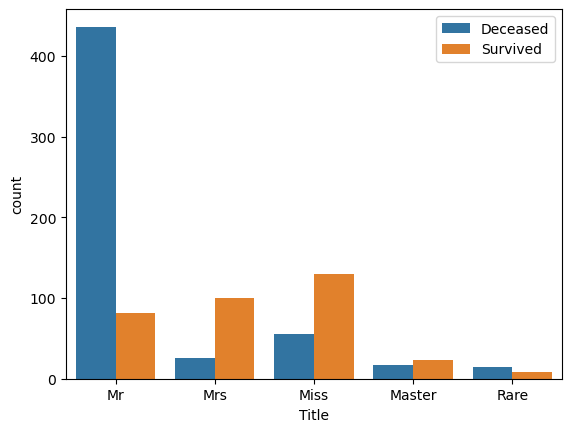

In [12]:
sns.countplot(x = "Title", hue = "Survived", data = tds, palette=["C0", "C1"]).legend(labels = ["Deceased", "Survived"])

In [13]:
tds["Title"].replace(["Mr", "Rare", "Master", "Miss", "Mrs"], [0, 1, 2, 4, 3], inplace = True)
tds[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,0,0.156673
1,1,0.347826
2,2,0.575000
3,3,0.793651
4,4,0.702703


In [14]:
#Find the relation between Pclass and Survival
tds["Pclass"].replace([1, 2, 3], [2, 1, 0], inplace = True)
tds[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
2,2,0.629630
1,1,0.472826
0,0,0.242363


In [15]:
#Find the relation between SibSp and Survival
tds[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [16]:
#Find the relation between Parch and Survival
tds[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


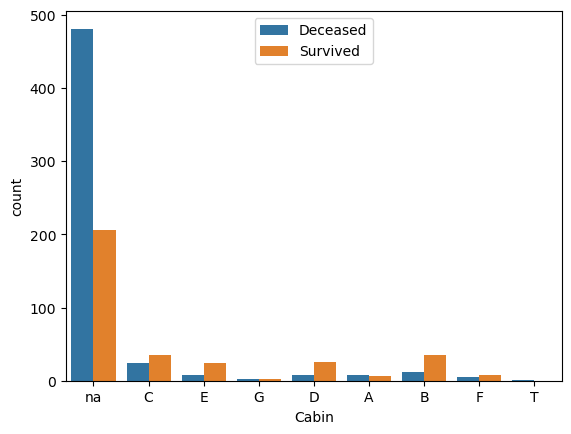

In [17]:
tds["Cabin"] = tds["Cabin"].apply(lambda x : x[0] if pd.notna(x) else "na")
sns.countplot(x = "Cabin", hue = "Survived", data = tds, palette=["C0", "C1"]).legend(labels = ["Deceased", "Survived"])

In [18]:
tds[["Cabin", "Survived"]].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Cabin,Survived
3,D,0.757576
4,E,0.750000
1,B,0.744681
5,F,0.615385
2,C,0.593220
6,G,0.500000
0,A,0.466667
8,na,0.299854
7,T,0.000000


In [19]:
tds.Cabin.unique()

array(['na', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [20]:
# Label_Encoding 
tds["Cabin"].replace(['na', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], [1, 4, 7, 3, 8, 2, 6, 5, 0], inplace = True)
tds["Embarked"].replace(['C', "Q", "S"], [2, 1, 0], inplace = True)

Text(0.5, 1.0, 'Missing values heatmap')

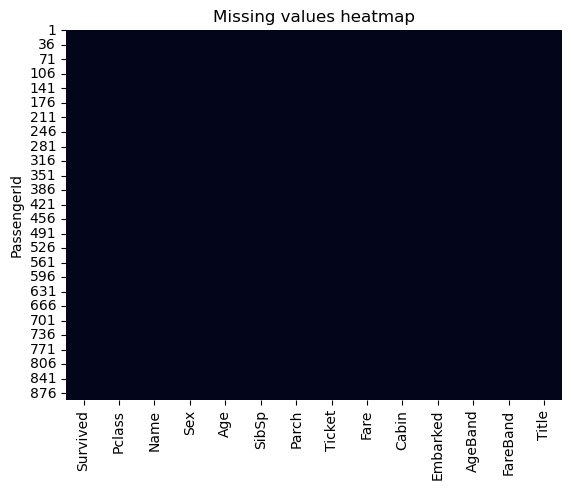

In [21]:
sns.heatmap(tds.isnull(), cbar = False).set_title("Missing values heatmap")

In [22]:
tds = tds.drop(["Name", "Ticket", "Age", "Fare"], axis = 1)
tds

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Embarked,AgeBand,FareBand,Title
PassengerId,,,,,,,,,,
1,0,0,0,1,0,1,0,1,0,0
2,1,2,1,1,0,4,2,2,0,3
3,1,0,1,0,0,1,0,1,0,4
4,1,2,1,1,0,4,0,2,0,3
5,0,0,0,0,0,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
887,0,1,0,0,0,1,0,1,0,1
888,1,2,1,0,0,6,0,1,0,4
889,0,0,1,1,2,1,0,1,0,4


In [23]:
tds.corr()

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Embarked,AgeBand,FareBand,Title
Survived,1.000000,0.338481,0.543351,-0.035322,0.081629,0.328063,0.167675,-0.037059,0.165780,0.547205
Pclass,0.338481,1.000000,0.131900,-0.083081,-0.018443,0.660275,0.162098,0.418829,0.347834,0.101240
Sex,0.543351,0.131900,1.000000,0.114631,0.245489,0.160274,0.108262,-0.074935,0.118639,0.949240
SibSp,-0.035322,-0.083081,0.114631,1.000000,0.414838,-0.041693,-0.068230,-0.228739,0.022148,0.199207
Parch,0.081629,-0.018443,0.245489,0.414838,1.000000,0.028468,-0.039798,-0.150458,0.139083,0.291817
Cabin,0.328063,0.660275,0.160274,-0.041693,0.028468,1.000000,0.140830,0.261144,0.252812,0.134484
Embarked,0.167675,0.162098,0.108262,-0.068230,-0.039798,0.140830,1.000000,0.015525,0.203933,0.107094
AgeBand,-0.037059,0.418829,-0.074935,-0.228739,-0.150458,0.261144,0.015525,1.000000,0.080791,-0.188478
FareBand,0.165780,0.347834,0.118639,0.022148,0.139083,0.252812,0.203933,0.080791,1.000000,0.121274
Title,0.547205,0.101240,0.949240,0.199207,0.291817,0.134484,0.107094,-0.188478,0.121274,1.000000


In [24]:
y = tds.iloc[:, 0]
x = tds
x.drop(["Survived"], inplace = True, axis = 1)
x_train, x_test, y_train, y_test = tts(x, y, test_size = 0.2, stratify = y)

In [25]:
def logistic(x):
    """
    Computes the logistic function applied to an input scalar/array
    Args:
        x (scalar/ndarray): scalar or numpy array of any size
    Returns:
        y (scalar/ndarray): logistic function applied to x, has the same shape as x
    """
    y = 1 / (1 + np.exp(-x))
    return y


def log_loss(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (scalar): true value (0 or 1)
      y_dash (scalar): predicted value (probability of y being 1)
    Returns:
      loss (float): nonnegative loss corresponding to y and y_dash
    """
    loss = - (y * np.log(y_dash)) - ((1 - y) * np.log(1 - y_dash))
    return loss


def cost_func_vec(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (array_like, shape (m,)): array of true values (0 or 1)
      y_dash (array_like, shape (m,)): array of predicted values (probability of y being 1)
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash
    """
    assert len(y) == len(y_dash), "Length of true values and length of predicted values do not match"
    m = len(y)
    loss_vec = np.array([log_loss(y[i], y_dash[i]) for i in range(m)])
    cost = np.dot(loss_vec, np.ones(m)) / m
    return cost


def cost_func_vec(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (array_like, shape (m,)): array of true values (0 or 1)
      y_dash (array_like, shape (m,)): array of predicted values (probability of y being 1)
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash
    """
    assert len(y) == len(y_dash), "Length of true values and length of predicted values do not match"
    m = len(y)
    loss_vec = np.array([log_loss(y[i], y_dash[i]) for i in range(m)])
    cost = np.dot(loss_vec, np.ones(m)) / m
    return cost


def cost_logreg_vec(X, y, w, b):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    z = np.matmul(X, w) + (b * np.ones(m))
    y_dash = logistic(z)
    cost = cost_func_vec(y, y_dash)
    return cost


def grad_logreg_vec(X, y, w, b): 
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    y_dash = logistic(np.matmul(X, w) + b * np.ones(m))
    grad_w = np.matmul(y_dash - y, X) / m
    grad_b = np.dot(y_dash - y, np.ones(m)) / m
    return grad_w, grad_b


def grad_desc(X, y, w, b, alpha, n_iter, show_cost = True, show_params = False): 
    """
    Implements batch gradient descent algorithm to learn and update model parameters
    with prespecified number of interations and learning rate
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): true values of target (0 or 1)
      w (array_like, shape (n,)): initial value of weight parameters
      b (scalar)                : initial value of bias parameter
      cost_func                 : function to compute cost
      grad_func                 : function to compute gradients of cost with respect to model parameters
      alpha (float)             : learning rate
      n_iter (int)              : number of iterations
    Returns:
      w (array_like, shape (n,)): updated values of weight parameters
      b (scalar)                : updated value of bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost_history, params_history = [], []
    for i, j in itertools.product(range(n_iter), range(1)):
        grad_w, grad_b = grad_logreg_vec(X, y, w, b)   
        w += - alpha * grad_w
        b += - alpha * grad_b
        cost =  cost_logreg_vec(X, y, w, b)
        cost_history.append(cost)
        params_history.append([w, b])
        if show_cost == True and show_params == False and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Epoch {i:6}:    Cost  {float(cost_history[i]):3.4f}")
        if show_cost == True and show_params == True and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Epoch {i:6}:    Cost  {float(cost_history[i]):3.4f},    Params  {params_history[i]}")
    return w, b, cost_history, params_history


def conf_mat(y_true, y_pred):
    """
    Computes confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      confusion_mat (array): A 2D array representing a 2x2 confusion matrix
    """
    y_true, y_pred = list(y_true), list(y_pred)
    count, labels, confusion_mat = len(y_true), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_true[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat


def conf_mat_heatmap(y_true, y_pred):
    """
    Prints confusion matrix
    Args:
      y_true (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      Nothing, prints a heatmap representing a 2x2 confusion matrix
    """
    confusion_mat = conf_mat(y_true, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

In [27]:
w_init = np.random.rand(9).astype(float)
b_init = -1.

w_out, b_out, cost_history, params_history = grad_desc(x_train.to_numpy(),
                                                       y_train.to_numpy(),
                                                       w = w_init, # np.zeros(X_train.shape[1]),
                                                       b = b_init, # 0,
                                                       alpha = 0.1,
                                                       n_iter = 200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch      0:    Cost  1.0816
Epoch     20:    Cost  0.5690
Epoch     40:    Cost  0.4876
Epoch     60:    Cost  0.4577
Epoch     80:    Cost  0.4448
Epoch    100:    Cost  0.4385
Epoch    120:    Cost  0.4352
Epoch    140:    Cost  0.4333
Epoch    160:    Cost  0.4322
Epoch    180:    Cost  0.4316
Epoch    199:    Cost  0.4312


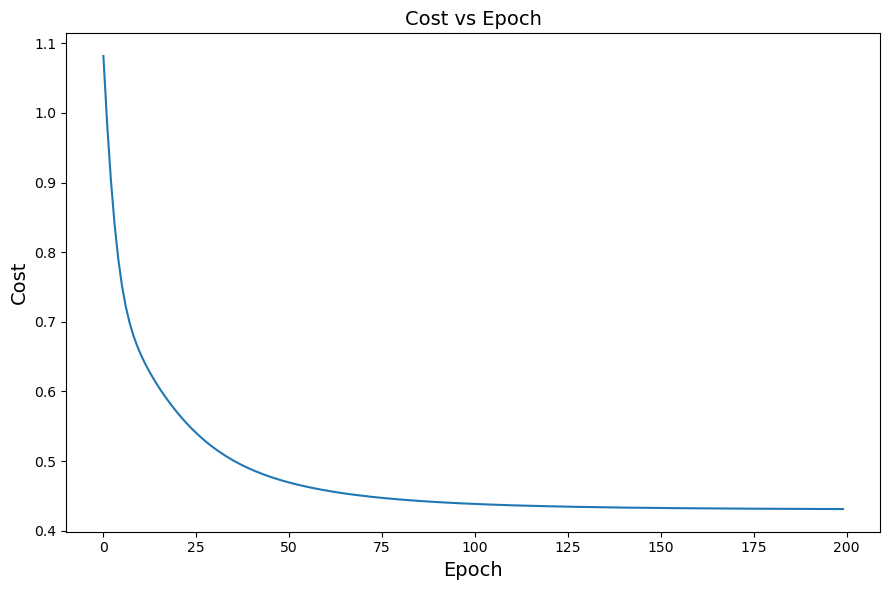

In [28]:
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Epoch", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Epoch", fontsize = 14)
plt.tight_layout()
plt.show()

In [29]:
params_history[-1]

[array([ 0.86975775,  0.60363047, -0.30169926, -0.00379443,  0.15506195,
         0.12201344, -0.52616876,  0.06480029,  0.58930881]),
 -1.7064652764718116]

In [30]:
y_train_prob = logistic(np.matmul(x_train.to_numpy(), w_out) + (b_out * np.ones(x_train.shape[0])))
y_train_pred = (y_train_prob > 0.5).astype(int)
print(f"Training accuracy: {accuracy_score(y_train, y_train_pred)}\nTraining recall: {recall_score(y_train, y_train_pred)}\nTraining f1 score: {f1_score(y_train, y_train_pred)}")

Training accuracy: 0.8174157303370787
Training recall: 0.7289377289377289
Training f1 score: 0.7537878787878788


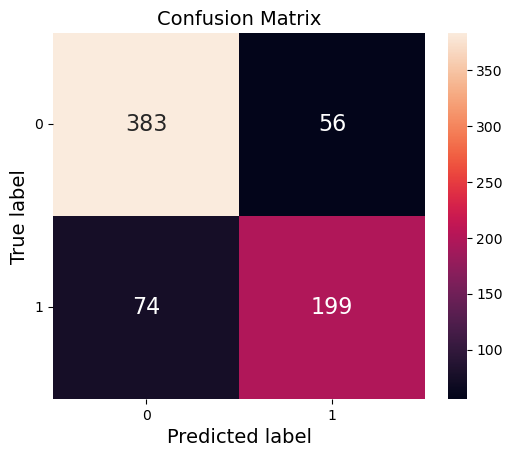

In [31]:
conf_mat_heatmap(y_train, y_train_pred)

In [32]:
y_test_prob = logistic(np.matmul(x_test.to_numpy(), w_out) + (b_out * np.ones(x_test.shape[0])))
y_test_pred = (y_test_prob > 0.5).astype(int)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}\nTest recall: {recall_score(y_test, y_test_pred)}\nTest f1 score: {f1_score(y_test, y_test_pred)}")

Test accuracy: 0.8212290502793296
Test recall: 0.7971014492753623
Test f1 score: 0.7746478873239437


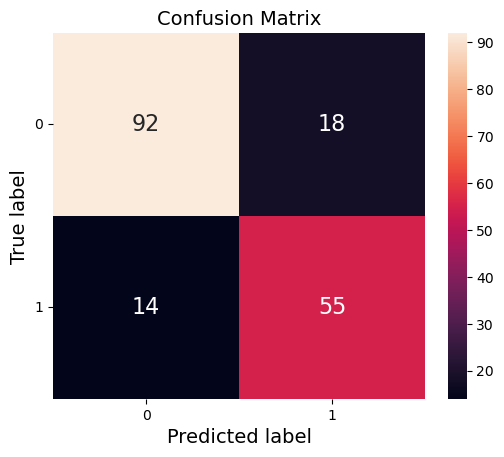

In [33]:
conf_mat_heatmap(y_test, y_test_pred)